<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/Widen00-Lab1/Lab1/Widen00_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DD2363 Lab 1: Matrix Factorization**
**Joel Widén**

# **Abstract**

This report is investigating different ways to directly solve matrix equations. A big part of this is factorizing matrices into forms that are more easily calculated or inverted. In this report the methods used are sparse matrix matrix vector multiplication and QR factorization. These methods are used and tested according to stated test cases. All the methods performed as expected which was expected. These methods allows for either faster calculations such as the sparse matrix multiplication or clever ways of dealing with direct matrix equations where the matrix might not be easily invertible.

#**About the code**

This is a report about matrix factorization in the course DD2363 Methods in Scientific Computing. The author of this file is Joel Widén, joelwid@kth.se.

# **Set up environment**


This block is run to set up the environment.


In [20]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Numbered algorithms, equations and chapter references used in this report is from the DD2363 course book [Methods in Computational Science by Johan Hoffman](https://epubs.siam.org/doi/book/10.1137/1.9781611976724) if not stated otherwise.

This report is investigating different methods of solving the direct matrix equation
$Ax = b$ (eq 5.1)
 by first implementing matrix factorization methods so that $x = A^{-1}b$ can be solved. This is split into several different assignments with the required output, input and test method of the function:

**Assignment 1:** Function: sparse matrix-vector product

  * *Input:* vector x, sparse (real, quadratic) matrix A: CRS arrays val, col_idx, row_ptr

  * *Output:* matrix-vector product b=Ax

  * *Test:* verify accuracy against dense matrix-vector product.

**Assignment 2:** Function: QR factorization

  * *Input:* (real, quadratic, invertible) matrix A

  * *Output:* orthogonal matrix Q, upper triangular matrix R, such that A=QR

  * *Test:* R upper triangular, Frobenius norms || Q^TQ-I ||_F, || QR-A ||_F

**Assignment 3:** Function: direct solver Ax=b

  * *Input:* (real, quadratic) matrix A, vector b

  * *Output:* vector x=A^-1b

  * *Test:* residual || Ax-b ||, and || x-y || where y is a manufactured solution with b=Ay

To complete assignment 1 algorithm 5.9 from the course book is implemented to calculate the matrix. This algorithm is chosen as it does exactly what is asked from the question as it calculates a sparse matrix vector product.

Assignment 2 was completed using algorithm 5.3 which is a modified gram-schmidt agorithm. This is used as the matrix A is factorized as a QR factorization as this specific algorithm does. It outputs Q as a orthogonal matrix and R as an upper triangular matrix.

Assignment 3 is solved using the QR-factorization from the previous assignment combined with algorithm 5.2 to solve the resulting problem which involves an upper triangular matrix.


# **Method**

Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

**Assignment 1: Sparse matrix vector product**
The sparse matrix algorithm uses the fact that the majority of the entries are zeroes and uses a clever system of pointers and id:s to deconstruct the information of a matrix in a more compact way. This data structure is called CRS or compressed row storage which is described in chapter 5.8. The algorithm can then utilize the fact of the rest of the entries being zeros to perform the matrix vector multiplication by using the CRS data. This is implemented in this assignment.

In [21]:
#Sparse matrix

#Sparse matrix vector product based on Algorithm 5.9
def sparse_matrix_vector_product(spA, x):
  n = max(spA.col_idx)
  b = np.zeros(n, dtype="int")
  for i in range(0, n):
    for j in range(spA.row_ptr[i]-1, spA.row_ptr[i+1]-1):
      b[i] = b[i] + spA.val[j]*x[spA.col_idx[j]-1]
  return b

x_1 = np.array([1, 1, 1, 1, 1, 1])
# From example 5.5
# Construct a simple sparse matrix class using the CRS data structure
class spMatrix:
  def __init__(self, val, col_idx, row_ptr):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr

# Create a sparse matrix object
val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10, 12])
spA = spMatrix(val, col_idx, row_ptr)

# Creating matrix for comparison dense calculation
A_sparse = np.array([[3, 2, 0, 2, 0, 0], [0, 2, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 3, 2, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 2, 3]])

#Calling function
b_sparse = sparse_matrix_vector_product(spA, x_1)
b_dense = A_sparse.dot(x_1)

**Assignment 2: QR-factorization**

QR factorization is a way of factorizing a square matrix $A$ into an orthogonal matrix Q and an upper triangular matrix $R$ such that $A = QR$ (chapter 5.3). This is useful as the inverse of a orthogonal matrix is the same as its transverse according to chapter 2.6. So $Q^T = Q^{-1}$. The upper trianguar matrix R has some useful properties which will be explained in the following assignment.


In [22]:
#QR factorization. Want to use modified grahm-schmidt algorithm

#Algorithm 5.3
def modified_gram_schmidt_iteration(A):
  n = len(A)
  R = np.zeros((n,n))
  Q = np.zeros((n,n))
  for j in range(0, n):
    v = A[:,j]
    for i in range(0, j):
      R[i][j] = Q[:,i].dot(v)
      v = v - R[i][j]*Q[:,i]
    R[j][j] = np.linalg.norm(v)
    Q[:,j] = v/R[j][j]
  return(Q, R)

# Vector for QR factorization and direct solving
A_inv = np.array([[2, -1], [-1, 2]])
#Call function
Q, R = modified_gram_schmidt_iteration(A_inv)
frob_1 = np.linalg.norm(Q.transpose().dot(Q) - np.identity(len(Q)), "fro")
frob_2 = np.linalg.norm(Q.dot(R) - A_inv, "fro")

**Assignment 3: Direct solver**
To perform this calculation the factorized matrix from assignment 2 is used. This allows a rewrite of $Ax=b$ as

$QRx = b ⇒ Rx = Q^Tb$

since $QQ^T = I$ according to the definition of orthogonal matrices. This is a new equation which can be solved for $x$ by implementing a backward substitution algorithm since $R$ is an upper triangular matrix.

In [23]:
# Direct Solver. Previous block must be run before this one.
# Direct Solver will be using QR factorization for inverting A using Q and R
# from previous assignment. Q is orthogonal and its inverse is equal to Q^T.
# Using backward substitution to solve R*x = Q^T*b as Ax = b => QRx = b

#Backwards substitution from algorithm 5.2
def backward_substitution(U,b):
  n = len(b)
  x = np.zeros(n)
  x[n-1] = b[n-1]/U[n-1,n-1]
  for i in range(n-2, -1, -1):
    sum = 0
    for j in range(i+1, n-2, -1):
      sum = sum + U[i][j]*x[j]
    x[i] = (b[i] - sum)/U[i][i]
  return x

#Function calling and vector definitions
y = np.array([15, 3])
b = A_inv.dot(y)
QTb = Q.transpose().dot(b)
x = backward_substitution(R, QTb)
residual = np.linalg.norm(A_inv.dot(x)-b)
error = np.linalg.norm(x-y)

# **Results**

The result from the code is presented by running the code block below.

In [24]:
# Results assignment 1
print("Assignment 1")
if (b_sparse == b_dense).all():
  print("Question 1 verified with dense matrix")
print("Sparse matrix computated b =", b_sparse)
print("Dense matrix computated b =", b_dense)

# Results assignment 2
print("\n" + "Assignment 2")
print("Frobenius norm for Q^T*Q - I = ",frob_1)
print("Frobenius norm for Q*R - A = ",frob_2)
print("Q = ", Q)
print("R = ", R)

# Results assignment 3
print("\n" + "Assignment 3")
print("Solution x=", x)
print("Residual: ", residual)
print("Error: ", error)

Assignment 1
Question 1 verified with dense matrix
Sparse matrix computated b = [7 3 1 5 1 5]
Dense matrix computated b = [7 3 1 5 1 5]

Assignment 2
Frobenius norm for Q^T*Q - I =  2.6901577681355055e-16
Frobenius norm for Q*R - A =  0.0
Q =  [[ 0.89442719  0.4472136 ]
 [-0.4472136   0.89442719]]
R =  [[ 2.23606798 -1.78885438]
 [ 0.          1.34164079]]

Assignment 3
Solution x= [15.  3.]
Residual:  7.944109290391274e-15
Error:  6.661338147750939e-15


# **Discussion**

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report?

# **APPENDIX**

In this appendix some examples are given to express and visualizing mathematical concepts such as vectors, matrices, meshes and functions.

This is not part of the template report for the course.

# **Vector**

In this cell some basic commands are introduced for how to define and process a vector, where the NumPy array data type is used.

x = [1 2 3 4]
x[2] = 3
x[0:2] = [1 2]
x.shape = (4,)
x.ndim = 1
x.size = 4
x.dtype = int64
x[ 0 ] = 1
x[ 1 ] = 2
x[ 2 ] = 3
x[ 3 ] = 4
x = [1 2 3 4]
xf = [1.  2.1 3.  4. ]
xf.dtype = float64
y = [2.+0.j 3.+0.j 4.+0.j]
y.dtype = complex128
z = [12.  16.5 21.  25.5]
z = [0.         1.57079633 3.14159265 4.71238898 6.28318531]


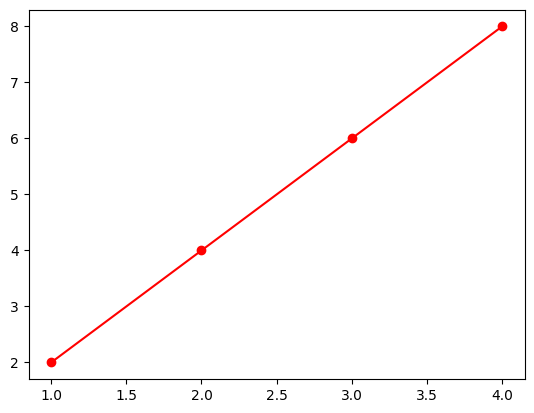

In [25]:
# Just a test
# Create a vector as a NumPy array
x = np.array([1,2,3,4])

# Print various attributes of the vector
print('x =',x)
print('x[2] =',x[2])
print('x[0:2] =',x[0:2])
print('x.shape =',x.shape)
print('x.ndim =',x.ndim)
print('x.size =',x.size)
print('x.dtype =',x.dtype)

# Print the elements of vector x
for i in range(x.size):
  print("x[",i,"] =",x[i])

# Assign a float value to the int vector x
x[1] = 2.1
print('x =',x)

# Copy the int vector x to a float vector xf
xf = x.astype(float)
xf[1] = 2.1
print('xf =',xf)
print('xf.dtype =',xf.dtype)

# Create a complex vector
y = np.array([2,3,4], dtype=complex)
print('y =',y)
print('y.dtype =',y.dtype)

# Create a vector z by defining a range through an increment
z = np.arange(12, 28, 4.5)
print('z =',z)

# Overwrite the vector z by a vector of uniformly spaced elements in a range
pi=np.pi
pi
z = np.linspace(0, 2*pi, 5)
print('z =',z)

# Visualize the vector in a plot.
plt.figure()
plt.plot(x,2*x,'ro-')
plt.show()

# **Matrix**

In this cell some basic commands for defining and processing a matrix
is introduced, where we use the NumPy array data type.

A = [[2 4 6]
 [3 6 9]
 [1 2 1]]
A[1,0] = 3
A.shape = (3, 3)
A.ndim = 2
A.size = 9
Sparse matrix values: 
 [3 2 2 2 1 1 3 2 1 2 3]
Sparse matrix column indices: 
 [1 2 4 2 3 3 3 4 5 5 6]
Sparse matrix row pointer: 
 [ 1  4  6  7  9 10]


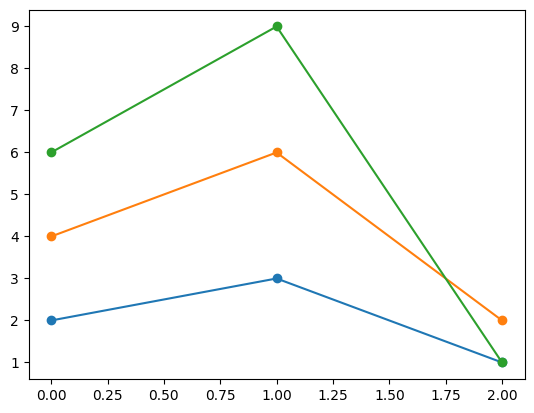

In [26]:
# Define a matrix as a NumPy array
A = np.array([[2,4,6], [3,6,9], [1,2,1]])

# Print various attributes of the matrix
print('A =',A)
print('A[1,0] =',A[1,0])
print('A.shape =',A.shape)
print('A.ndim =',A.ndim)
print('A.size =',A.size)

# Plot the matrix
plt.figure()
plt.plot(A,'o-')

# Construct a simple sparse matrix class using the CRS data structure
class spMatrix:
  def __init__(self, val, col_idx, row_ptr):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr

# Create a sparse matrix object
val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10])
spA = spMatrix(val, col_idx, row_ptr)

# Print sparse matrix object attributes
print('Sparse matrix values: \n',spA.val)
print('Sparse matrix column indices: \n',spA.col_idx)
print('Sparse matrix row pointer: \n',spA.row_ptr)


# **Function**

In this cell we illustrate how functions are defined.

f(3,4) = 7
z = 13
z = 17
z = 14
A = [[1 2 3]
 [4 5 6]
 [7 8 9]]
A =
1  2  3  
4  5  6  
7  8  9  
A^T =
1  4  7  
2  5  8  
3  6  9  


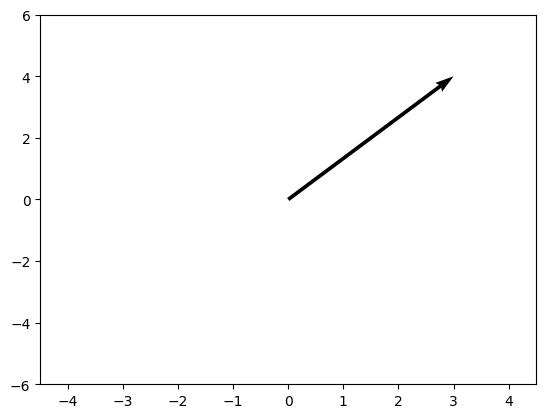

In [27]:
# Define a function f(x,y)
def f(x,y):
  return x + y

# Verify the function output
print('f(3,4) =',f(3,4))

# Define a function of a function
def g1(fcn,arg1,arg2):
  z = fcn(arg1,arg2)
  print('z =',z)

# Call the function
g1(f,6,7)

# Define a function of a function with arguments in a list or array
def g2(fcn,arg):
  z = fcn(*arg)
  print('z =',z)

# Call the function with arguments as list and array
xlist = [8,9]
xarray = np.array([11,3])
g2(f,xlist)
g2(f,xarray)

# Define a function to format the print out for a matrix
def printMatrix(A):
   rows = A.shape[0]
   cols = A.shape[1]
   for i in range(0,rows):
      for j in range(0,cols):
         print(A[i,j]," ", end='')
      print()

# Define matrix
A = np.array([[1,2,3], [4,5,6], [7,8,9]])

# Verify the function output
print('A =', A)
print('A =')
printMatrix(A)
print('A^T =')
printMatrix(A.transpose())

# Plot a Euclidian position vector v
def plotEVector(vec):
  plt.figure()
  plt.xlim([-1.5*vec[0], 1.5*vec[0]])
  plt.ylim([-1.5*vec[1], 1.5*vec[1]])
  plt.quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy', angles='xy')
  plt.show()

v = np.array([3,4])
plotEVector(v)




# **Plot**

<Figure size 640x480 with 0 Axes>

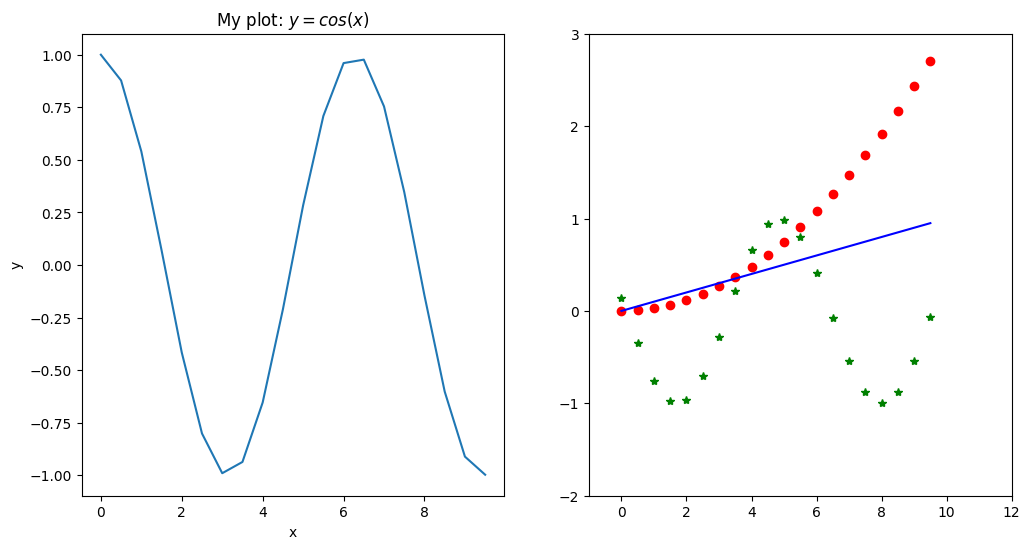

In [28]:
# Define a range for a parameter t
t = np.arange( 0.0, 10, 0.5)

# Initialize a new figure and set the size
plt.figure(2)
plt.figure(figsize=(12,6))

# Define a subplot structure and choose the first subplot
plt.subplot(121)

# Plot a standard NumPy function against the parameter t
plt.plot(t,np.cos(t))

# Set plot labels and title for the subplot
plt.xlabel('x')
plt.ylabel('y')
plt.title('My plot: $y = cos(x)$')

# Choose the other subplot
plt.subplot(122)

# Plot three functions in the same subplot
plt.plot(t, np.sin(f(t,3)), 'g*', t, 0.03*t**2, 'ro', t, 0.1*t, 'b')
plt.axis([-1, 12, -2 ,3])

# Show the figure
plt.show()

# Triangular **mesh**

This cell describes how to generate a triangular mesh from a point cloud by the Delaunay algorithm. It also illustrates how to access the mesh data structures.

Mesh generation took:  0.001081705093383789 seconds (wall-clock time)
vertices = 
 [[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
  1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.  ]
 [0.   0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5
  0.5  0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.   1.  ]]
edges = 
 [[ 1  0]
 [ 2  1]
 [ 3  2]
 [ 4  3]
 [ 5  0]
 [ 5  1]
 [ 6  1]
 [ 6  5]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  6]
 [ 8  3]
 [ 8  7]
 [ 9  3]
 [ 9  4]
 [ 9  8]
 [10  5]
 [11  5]
 [11  6]
 [11  7]
 [11 10]
 [12  7]
 [12 11]
 [13  7]
 [13  8]
 [13  9]
 [13 12]
 [14  9]
 [14 13]
 [15 10]
 [15 11]
 [16 11]
 [16 15]
 [17 11]
 [17 12]
 [17 13]
 [17 16]
 [18 13]
 [18 17]
 [19 13]
 [19 14]
 [19 18]
 [20 15]
 [21 15]
 [21 16]
 [21 17]
 [21 20]
 [22 17]
 [22 21]
 [23 17]
 [23 18]
 [23 19]
 [23 22]
 [24 19]
 [24 23]]
triangles = 
 [[ 0  1  5]
 [ 5  1  6]
 [ 9  3  4]
 [ 8  3  9]
 [ 6  1  7]
 [ 7  1  2]
 [ 7  3  8]
 [ 2  3  7]
 [20 15 21]
 [21 15 16]
 [ 6  7 

<Figure size 640x480 with 0 Axes>

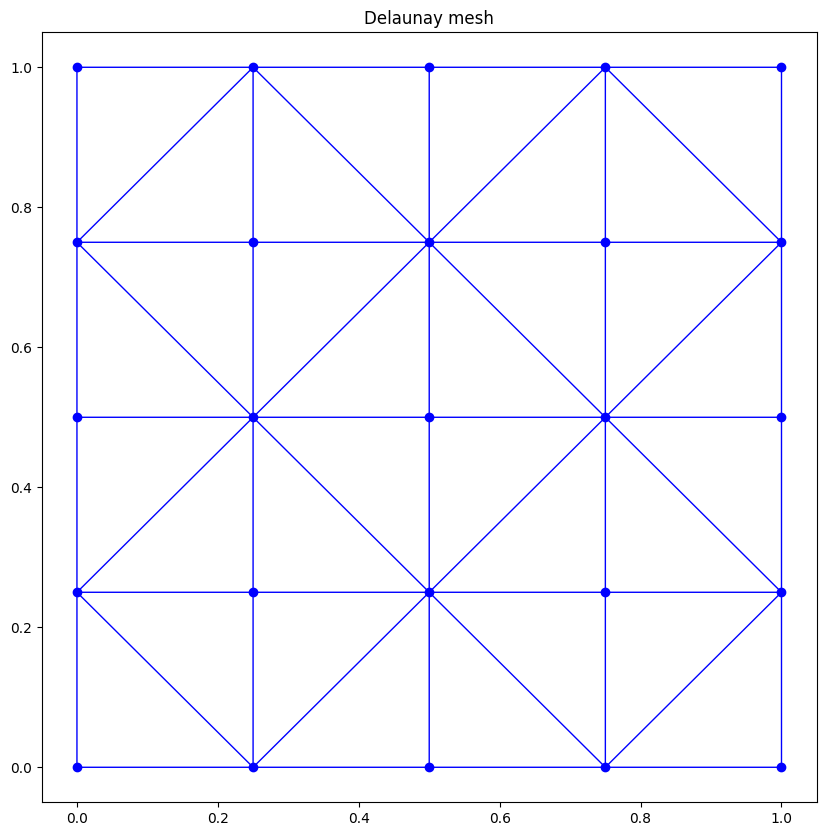

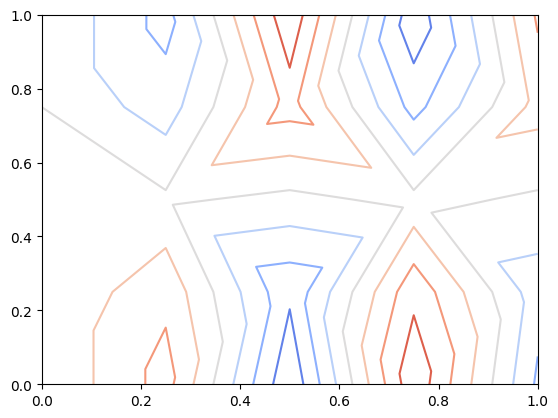

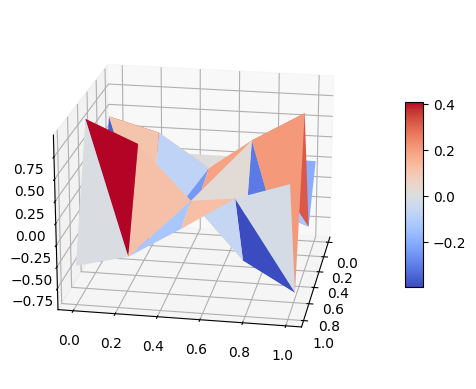

In [29]:
# Start the clock
start = time.time()

# Generate a point cloud
Nx = 5
Ny = 5
hx = 1.0/(Nx-1)
hy = 1.0/(Ny-1)
x = np.zeros((Nx*Ny))
y = np.zeros((Nx*Ny))
for i in range(Nx):
  for j in range(Ny):
    x[i*Nx + j] = j*hx
    y[i*Nx + j] = i*hy

# Generate a mesh from the point cloud using a Delaunay algorithm
mesh = tri.Triangulation( x, y )

# Stop the clock
end = time.time()

# Print the measured time
print ("Mesh generation took: ", end - start, "seconds (wall-clock time)")

# Print mesh data structure
vertices = np.array([mesh.x, mesh.y])
print('vertices = \n', vertices)
print('edges = \n', mesh.edges)
print('triangles = \n', mesh.triangles)
print('neighbor triangles = \n', mesh.neighbors)

# Plot the mesh
plt.figure(3)
plt.figure(figsize=(10,10))
plt.triplot(mesh, 'bo-', lw=1)
plt.title('Delaunay mesh')
plt.show()

# Define a function g(x,y)
def g(x,y):
    return np.sin(10*x)*np.cos(3*y)

# Plot the function g(x,y) in a contour plot
plt.figure(4)
plt.tricontour(mesh, g(x,y), cmap=plt.cm.coolwarm)
plt.show()

# Plot the function g(x,y) in 3D as a surface plot
fig = plt.figure(5)
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_trisurf(mesh, g(x,y), cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax1.view_init(20,10)
plt.show()

# Parametric **curve**

This cell illustrates how to visualize a parametric curve.

In [30]:
# Define paramter range
t = np.linspace(0, 4*np.pi, 100)

# Define the curve
x = t*np.cos(t)
y = t*np.sin(t)
z = t

fig = plt.figure(6)
ax = fig.gca(projection = '3d')
ax.plot(x, y, z)
plt.title('Parametric curve')
plt.show()

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>